### Final setting
After trying the different settings of model hyperparameters and model structure, including the number of ResBlocks and the number of dimension reduction layers (linear layers) We find that the best setting up to now is to have 1 ResBlock and two linear layers before and after the ResBlock. The first intermediate dimension is set to 256. The hidden dimension was set to 3. 3 was chosen as it is the middle between two and four. 2 might be too small and the representation it takes might not be that valid analytically. In addition, 2 is not that well-performing compared with 3 and 4. In contrast, 4 is well-performing. And of course, the more dimensions we have, it might be therefore closer to what we have in brain because we are not sure how many dimensions are there in the brain. However, because 4 is not easy to be plotted graphically, if we want to directly plot them without doing any additional PCA transformation, 4 dimensions might not be that's suitable. Therefore, we chose the middle 3, 3 is OK in terms of performance. And also OK for plotting. 

In addition, we will train the model for around 20 epochs. 

### Core changes done compared with very original model last sem
1. Reduced hidden dimension (latent dim) to 3, which is not a large number but still allows considerable dimensionality of phoneme system. 
2. Reduced 3 ResBlocks to 2 ResBlocks, which alleviates the influence of reducing hidden dimension on HCV scores. The training and validation loss, though, cannot be solved by reducing number of ResBlocks. 
3. The resulting HCV score was satisfactory, which is not very much affected by the change. 

### Task here
After many trials, it was found that changing the model structure might not bring advantage. Downsizing the hidden dimensions usually highers loss and lowers HCV scores. But by reducing the number of ResBlocks it can be alleviated. 

This time I will try to recover to the old model but just 1. reduce hidden dim to 4 or 3 (2 is okay as well, but might be too simple? ), and 2. reduce number of Res block. 

### Core task
The core task for this copy is to test models with less parameters and see whether they can still catch the phonetic system. 

In this round's revision, the most important thing is to verify that the model is really doing something, that what we have is really due to having the model. 

One thing to note is that we should not deny that the input data themselves are having a phonetic system, it actually must be so, because the model (and even human) is just expecte to learn and extract this knowledge from the naturally existing structure of sounds. So we cannot run a phoneme evaluation on MFCCs (or even raw wav data) and declare that our model is not making things better. No, the original thing is the best, we are trying to verify that after some kind of learning and abstraction, whether the phonetic system can be copied into the knowledge of our learner. 

In [ ]:
# Mount Google Drive: connect to google drive storage
# Should be changed to other codes when using HPC or running locally. 
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
main_dir = '/content/drive/My Drive/FeatureLearning/'

# (Ref.: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab)
import sys, os
sys.path.append(main_dir)
# os.listdir(main_dir)

Mounted at /content/drive


In [ ]:
import zipfile
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import datetime as dt
import shutil
import numpy as np
import csv
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle

In [ ]:
#################################################################
#             Directory              #
#################################################################

root_dir = "/content/"
base_dir = "/content/drive/My Drive/"
working_dir = base_dir + "FeatureLearning/"

src_dir = working_dir + "src/"
corpus_dir = src_dir + "bsc/"
cons_dir = corpus_dir + "consonants/"
full_seg_dir = corpus_dir + "fullchunk/"
full_sample_dir = corpus_dir + "fullchunksample/"

save_dir = working_dir + "modelsave/english/"

train_name = full_sample_dir + "fullchunk"

tags_name = full_seg_dir + "tags"
test_name = full_seg_dir + "fullchunk"

In [ ]:
#################################################################
#             Constants              #
#################################################################
EPOCHS = 10
BATCH_SIZE = 128

FRAMES_IN_SEGMENT = 25
SEGMENTS_IN_CHUNK = 100  # set_size

MFCC_DIM = 13
INPUT_DIM = FRAMES_IN_SEGMENT * MFCC_DIM * 3
OUTPUT_DIM = FRAMES_IN_SEGMENT * MFCC_DIM
# let's still maintain these interdims but just ignore them when building the model 
INTER_DIM_1 = 256
INTER_DIM_2 = 64
INTER_DIM_3 = 16
LATENT_DIM = 3

DROPOUT = 0.5

In [ ]:
#################################################################
#              Utils               #
#################################################################
def get_timestamp():
    # for model save
    return dt.datetime.now().strftime("%m%d%H%M%S")   # timestamp ignores year and second, not really needed. 

In [ ]:
# To construct own PyTorch Dataset instance, need to specify:
# - how to retrieve a data entry
# - how to process a data entry 
class UngroundedSoundDataset(Dataset): 
    def __init__(self, train_name, chunks, suffix) :
        # Now we enable the dataset loader to read in multiple chunks at a time and and can catenate them until one single piece
        self.dataset = None
        for chunk in chunks: 
            path = train_name + chunk + suffix
            if self.dataset is None: 
                self.dataset = np.load(path)
            else: 
                self.dataset = np.concatenate((self.dataset, np.load(path)))
        
    # REQUIRED: provide size of dataset (= #images)
    def __len__(self) :
        return self.dataset.shape[0]
        # return sum(self.clip_meta["chunk_size"].tolist())

    def __getitem__(self, idx): 
        inp = torch.from_numpy(self.dataset[idx]).to(torch.float32)
        outp = inp[:, :13]
        return inp, outp

In [ ]:
# To construct own PyTorch Dataset instance, need to specify:
# - how to retrieve a data entry
# - how to process a data entry 
class GroundedSoundDataset(Dataset): 
    def __init__(self, tags, chunk, full_chunk=True, set_size=50) :
        """
        Custom PyTorch Dataset class to load and process image data and labels.
        For each input data entry:
        1. Calculate the chunk num and within-chunk idx from the given idx
        2. Load that chunk from disk and get out the corresponding segment
        3. Although we're using autoencoder, according to Shain & Elsner (2019), 
            the input and output dimensions are not exactly the same. 
            The input includes mfcc, delta and its second order delta, 
            whereas the output only has mfccs. Since the deltas could be 
            calculated from mfccs, there is no need to learn to output them. 
            → the get function need to prepare two copies of segments: 39dim and 13dim. 

        Note that a chunk includes segments, a segment includes n (25) frames of mfccs. 

        Inputs: 
            clip_meta: metadata in pandas dataframe format. Including file_general_name and chunk_size. 
            chunksdir: directory of mfcc chunk files
            set_size: number of segments in a standard-size chunk. default to 50. 
        """
        # Store inputs for later use
        # we suppose that clip_meta is ordered in chunk_size, 
        # therefore standard chunks are always together and after nonstandard chunks. 
        self.tags = tags
        if full_chunk: 
            self.dataset = np.load(chunk)
            self.dataset_tags = self.tags["tag"]
            assert self.dataset.shape[0] == self.dataset_tags.shape[0]
        else: 
            pass    # try first, not filled in. 
        
    # REQUIRED: provide size of dataset (= #images)
    def __len__(self) :
        return self.dataset.shape[0]
        # return sum(self.clip_meta["chunk_size"].tolist())

    def __getitem__(self, idx): 
        inp = torch.from_numpy(self.dataset[idx]).to(torch.float32)
        outp = inp[:, :13]
        return inp, outp, self.dataset_tags[idx]

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.lin1 = nn.Linear(n_chans, n_chans)
        self.lin2 = nn.Linear(n_chans, n_chans)
        self.batch_norm = nn.BatchNorm1d(num_features=n_chans)  # <5>
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lin1(x)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.batch_norm(out)
        out = self.relu(out)
        return out + x

class LinPack(nn.Module):
    def __init__(self, n_in, n_out):
        super(LinPack, self).__init__()
        self.lin = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(num_features=n_out)
        # self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.lin(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        # x = self.dropout(x)
        return x


class ResAE(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, inter_dim1=INTER_DIM_1, inter_dim2=INTER_DIM_2, inter_dim3=INTER_DIM_3, latent_dim=LATENT_DIM, output_dim=OUTPUT_DIM):
        super(ResAE, self).__init__()

        self.encoder = nn.Sequential(
            LinPack(input_dim, inter_dim1), 
            ResBlock(inter_dim1), 
            # ResBlock(inter_dim1), 
            nn.Linear(inter_dim1, latent_dim), 
            # nn.Sigmoid()
        )

        self.decoder =  nn.Sequential(
            LinPack(latent_dim, inter_dim1), 
            ResBlock(inter_dim1), 
            # ResBlock(inter_dim1), 
            nn.Linear(inter_dim1, output_dim),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        org_size = x.size()
        y_size = (org_size[0], org_size[1], org_size[2] // 3)
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        recon_x = self.decoder(h).view(size=y_size)

        return recon_x

In [ ]:
recon_loss = nn.MSELoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResAE(INPUT_DIM, INTER_DIM_1, INTER_DIM_2, INTER_DIM_3, LATENT_DIM, OUTPUT_DIM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model

ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=3, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): Bat

In [ ]:
# Define recorders of training hists, for ease of extension
class Recorder: 
    def __init__(self, IOPath): 
        self.record = []
        self.IOPath = IOPath

    def save(self): 
        pass
    
    def append(self, content): 
        self.record.append(content)
    
    def get(self): 
        return self.record

In [ ]:
class LossRecorder(Recorder): 
    def read(self): 
        # only used by loss hists 
        with open(self.IOPath, 'rb') as f:
            self.record = pickle.load(f)
    
    def save(self): 
        with open(self.IOPath, 'wb') as file:
            pickle.dump(self.record, file)


class HistRecorder(Recorder):     
    def save(self): 
        with open(self.IOPath, "a") as txt:
            txt.write("\n".join(self.record))
    
    def print(self, content): 
        self.append(content)
        print(content)

In [ ]:
# Just for keeping records of training hists. 
# ts = str(get_timestamp())
ts = "0130021416"
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_hist_{}.hst".format(ts)
save_valhist_name = "val_hist_{}.hst".format(ts)

In [ ]:
valid_losses = LossRecorder(save_dir + save_valhist_name)
train_losses = LossRecorder(save_dir + save_trainhist_name)
text_hist = HistRecorder(save_dir + save_txt_name)

In [ ]:
READ = False
# READ = True

In [ ]:
if READ: 
    valid_losses.read()
    train_losses.read()

    # model_name = last_model_name
    model_name = "model_english_0130021416_9_full"
    model_path = save_dir + model_name + ".pt"
    state = torch.load(model_path)
    model = ResAE()
    model.load_state_dict(state)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

In [ ]:
best_loss = 1e9
best_epoch = 0
EPOCHS = 30
BASE = 0
train_seqs = ["_06_10", "_16_20", "_21_25", "_26_30", "_31_35"]   # "_31_35"
test_seqs = ["_01_05"]
last_model_name = ""

In [ ]:
# train_gsds = UngroundedSoundDataset(train_name, train_seqs, ".npy")
# train_loader = DataLoader(train_gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
# train_num = len(train_loader.dataset)

valid_gsds = UngroundedSoundDataset(train_name, test_seqs, ".npy")
valid_loader = DataLoader(valid_gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
valid_num = len(valid_loader.dataset)

In [ ]:
for epoch in range(BASE, BASE + EPOCHS):
    text_hist.print("Epoch {}".format(epoch))

    model.train()
    train_loss = 0.
    train_num = 0. 
    base = 0
    for chunk in train_seqs: 
        train_gsds = UngroundedSoundDataset(train_name, [chunk], ".npy")
        train_loader = DataLoader(train_gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        train_num += len(train_loader.dataset)
        for idx, (x, y) in enumerate(train_loader):
            idx += base    # for idx counting, not for other use
            batch = x.size(0)
            x = x.to(device)
            y = y.to(device)
            recon_x = model(x)
            recon = recon_loss(recon_x, y)

            loss = recon
            train_loss += loss.item()
            loss = loss / batch

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")
        base += len(train_loader)

    train_losses.append(train_loss / train_num)
    text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

    torch.save(model.state_dict(), 'model_english')
    last_model_name = "model_english_{}_{}_full".format(ts, epoch)
    shutil.move(root_dir + "model_english", save_dir + last_model_name + ".pt")
    text_hist.print("Training timepoint saved")

    model.eval()
    valid_loss = 0.

    for idx, (x, y) in enumerate(valid_loader):
        batch = x.size(0)
        x = x.to(device)
        y = y.to(device)
        recon_x = model(x)
        recon = recon_loss(recon_x, y)

        loss = recon
        valid_loss += loss.item()
        loss = loss / batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            # \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f}
            text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

    valid_losses.append(valid_loss / valid_num)
    text_hist.print(f"Valid loss {valid_loss / valid_num: .3f}※※※")

Epoch 0
Training loss  1.060 in Step 0
Training loss  0.508 in Step 100
Training loss  1.167 in Step 200
Training loss  1.015 in Step 300
Training loss  0.856 in Step 400
Training loss  0.894 in Step 500
Training loss  0.939 in Step 600
Training loss  0.675 in Step 700
Training loss  0.618 in Step 800
Training loss  0.796 in Step 900
Training loss  0.493 in Step 1000
Training loss  0.557 in Step 1100
Training loss  0.711 in Step 1200
Training loss  0.621 in Step 1300
Training loss  0.682 in Step 1400
Training loss  0.800 in Step 1500
Training loss  0.676 in Step 1600
Training loss  0.644 in Step 1700
Training loss  0.719 in Step 1800
Training loss  0.910 in Step 1900
Training loss  0.773 in Step 2000
Training loss  0.538 in Step 2100
Training loss  0.680 in Step 2200
Training loss  0.613 in Step 2300
Training loss  0.753 in Step 2400
Training loss  0.638 in Step 2500
Training loss  0.669 in Step 2600
Training loss  0.739 in Step 2700
Training loss  0.668 in Step 2800
Training loss  1.0

In [ ]:
### Save
valid_losses.save()
train_losses.save()
text_hist.save()

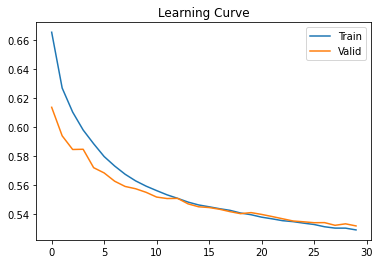

In [ ]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve")
plt.legend();

In [ ]:
ts

'0130021416'

We can see that with Sigmoid the model seems to perform slightly worse, but this should not be a big problem. Then the decision might depend more on whether the use of it is common and justifiable. I don't think it's common, and the use of it does not seem to be analytically necessary. 

In [ ]:
class ResAECluster(ResAE): 
    def __init__(self, input_dim=INPUT_DIM, inter_dim1=INTER_DIM_1, inter_dim2=INTER_DIM_2, inter_dim3=INTER_DIM_3, latent_dim=LATENT_DIM, output_dim=OUTPUT_DIM): 
        super().__init__(input_dim, inter_dim1, inter_dim2, inter_dim3, latent_dim, output_dim)

    def forward(self, x):
        org_size = x.size()
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        # mu, logvar = h.chunk(2, dim=1)
        # z = self.reparameterise(mu, logvar)

        return h

In [ ]:
seq = "_01_05"
tags = pd.read_csv(tags_name + seq + ".csv")
gsds = GroundedSoundDataset(tags, test_name + seq + ".npy")
eval_loader = DataLoader(gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
last_model_name

'model_english_0130021416_29_full'

In [ ]:
# model_name = last_model_name
model_name = "model_english_0130021416_13_full"
model_path = save_dir + model_name + ".pt"
state = torch.load(model_path)
model = ResAECluster()
model.load_state_dict(state)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
hiddens = None
tags = None
model.eval()
with torch.no_grad():
    for idx, (s, e, t) in enumerate(eval_loader):
        s = s.to(device)
        hidden = model(s)
        hidden = hidden.cpu().data.numpy()

        if hiddens is not None: 
            hiddens = np.concatenate((hiddens, hidden), axis=0)
            tags = np.concatenate((tags, t), axis=0)
        else: 
            hiddens = hidden
            tags = t
num_phones = np.unique(tags).shape[0]
kmeansmodel = KMeans(n_clusters=num_phones) # , random_state=0
clusters = kmeansmodel.fit_predict(hiddens)
np.save(save_dir + model_name + seq + "_hiddenclusters.npy", clusters)
np.save(save_dir + model_name + seq + "_hiddenrepresentation.npy", hiddens)


In [ ]:
h, c, v = homogeneity_completeness_v_measure(tags, clusters)

In [ ]:
print(seq, h, c, v) # trained on sampled data

_01_05 0.30813685860010276 0.2726217590636009 0.2892933823757265


In [ ]:
# _17_24 0.3429902101084872 0.329164358854651 0.33593508938856537   # 256+8
# _17_24 0.3071758873778334 0.2958512436337788 0.3014072290332542   # 128+4
# _17_24 0.3048181747064378 0.303971996633573 0.3043944976042278    # 128+2
# _17_24 0.3109960687106377 0.3020004935745723 0.3064322772063619   # 256+2, 2res
# _17_24 0.27632046463064963 0.29796767719078493 0.28673608598337974    # 256+64+2, 2res, new model
# _17_24 0.29619001674434664 0.30940705212658304 0.30265430485339223    # 256+64+4, 0res
# _17_24 0.3394207670351701 0.3356821861468344 0.33754112484613674      # 256+64+4, 2res
# _17_24 0.3246121630042821 0.3173438869288583 0.32093687897447765  # 256+3, 2res, not very bad. So we may try this. This is error, decoder only having 1 res
# _17_24 0.3227539602867097 0.32256957773330264 0.3226617426690128  # 256+3, 2res
# _17_24 0.3403517130774138 0.33762198107176034 0.33898135170147237 # 256+3, 1res
# _17_24 0.3202704367215642 0.31097127191607643 0.3155523587925454  # 256+3, 0res


# _01_05 0.30784101366300043 0.2717512535534188 0.28867252408265254

总的来说分成四个，神经网层来进行降维处理，得到的损失比较大，但是 hcv值倒是接近不过，如果能尽量的接近原作的模型结构，我们就不去动它了，所以可能目前来看最好的是保留两个降为层加上两个残差层，最后从256降到2，也许是最好的结果当然降到4也是可以的，都是比较低的维度，不过如果我们想要直接能够，在，可视的空间中画出这些点来，2或者3可能会比四更好一些。 

从使用不同数量残插块儿的实验结果来看，是由一个残渣块，应该是最好的解决方式，使用零个或两个第三个都可能是都会使hcv值相对降低。由此来看在选择，隐性层纬度为三的情况下，我们应该选择适用一个参差款。

### Conclusion
Adding new data slightly improves the performance of the model in HCV score, in addition, shuffling the training data largely lowers the HGV score perhaps we should discuss this phenomenon and justify use no shuffling during training. Perhaps this is because of some sort of phonotactics or naturalness of sound streams. 

Good news is that for the English model it performs similar well. 